# Extended Tofts model

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
[to do add some relevant background on the etofts model here]

## Test data

Digital reference object of the brain from Bosca et al. 2016.

Test case labels: test_vox_T{tumour voxel number}_{SNR},e.g. test_vox_T1_30
Selected voxels:
- datVIF=alldata[108,121,6,:]
- datT1=alldata[121,87,6,:] --> tumour voxel 1
- datT2=alldata[156,105,6,:] --> tumour voxel 2
- datT3=alldata[139,93,6,:] --> tumour voxel 3
SNR was added to obtain data at different SNR (20, 30, 50 and 100)


These are signal values, which were converted to concentration curves using dce_to_r1eff from https://github.com/welcheb/pydcemri/blob/master from David S. Smith

Input and reference values were found from the accompanying pdf document, which describes the values per voxel.
- T1 blood of 1440 ms
- T1 tissue of 1084 for white matter and 1820 for  grey matter, 1000 for T1-T3
- TR=5 ms
- FA=30
- Hct=0.45

Tolerances
- $v_e$: a_tol=0.05, r_tol=0, start=0.2, bounds=(0,1)
- $v_p$: a_tol=0.0025, r_tol=0, start=0.01, bounds=(0,1)
- $K^{trans}$: a_tol=0.005, r_tol=0.01, start=0.6, bounds=(0,5), units [/min]
- delay: a_tol=0.2, r_tol=0, start=0, bounds=(-10,10), units [s]

Source: Bosca, Ryan J., and Edward F. Jackson. "Creating an anthropomorphic digital MR phantom—an extensible tool for comparing and evaluating quantitative imaging algorithms." Physics in Medicine & Biology 61.2 (2016): 974.

### Visualize test data
showing the data from high SNR from the original DRO and lowest SNR of 20

<Figure size 432x288 with 0 Axes>

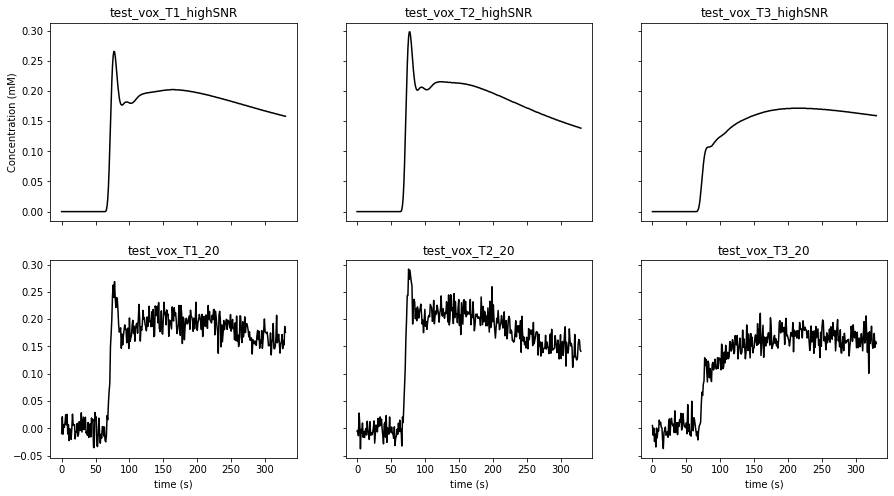

In [2]:
#plot test data
filename = ('../test/DCEmodels/data/dce_DRO_data_extended_tofts.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)
#print(df1)

plt.figure()
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8))
for currentvoxel in range(3):
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_highSNR'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[0,currentvoxel].plot(t, c, color='black', label='highSNR')
    ax[0,currentvoxel].set_title(labelname)
    if currentvoxel ==0:
        ax[0,currentvoxel].set_ylabel('Concentration (mM)')
    
    
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_20'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[1,currentvoxel].set_title(labelname)
    ax[1,currentvoxel].plot(t, c, color='black', label='SNR 20')
    ax[1,currentvoxel].set_xlabel('time (s)')
   
    

## Import data

In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == 'etofts') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('highSNR'),'source']='highSNR'
df.loc[df['label'].str.contains('_20'),'source']='SNR20'
df.loc[df['label'].str.contains('_30'),'source']='SNR30' 
df.loc[df['label'].str.contains('_50'),'source']='SNR50' 
df.loc[df['label'].str.contains('_100'),'source']='SNR100' 

author_list = df.author.unique()
no_authors = len(author_list)

# calculate error between measured and reference values
df['error_Ktrans'] = df['Ktrans_meas'] - df['Ktrans_ref']
df['error_ve'] = df['ve_meas']- df['ve_ref']
df['error_vp'] = df['vp_meas']- df['vp_ref']

# tolerances
tolerances = { 'Ktrans': {'atol' : 0.005, 'rtol': 0.01 },'ve': {'atol':0.05, 'rtol':0}, 'vp': {'atol':0.0025, 'rtol':0}}

## Results

The data of all test voxels are combined (low and high SNR)

<Figure size 432x288 with 0 Axes>

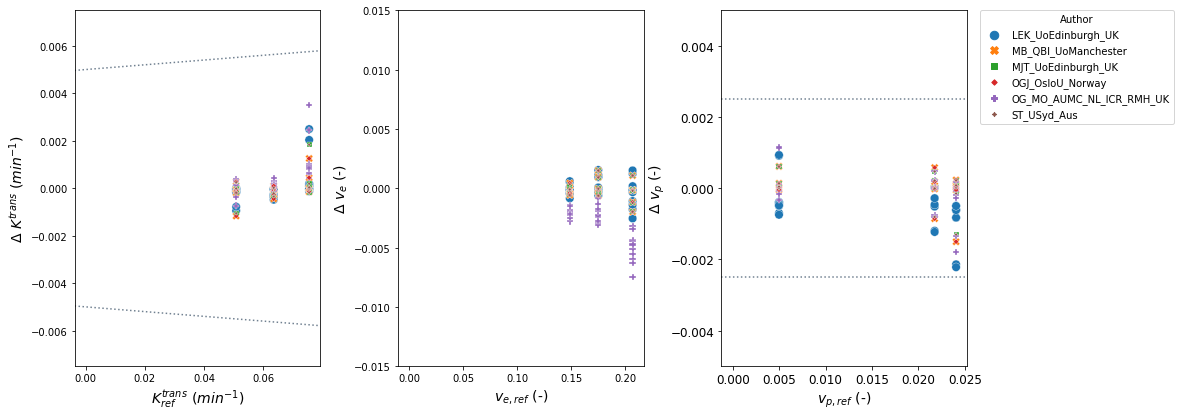

In [15]:
plt.figure()
fig, ax = plt.subplots(1,3, sharey='none', figsize=(15,6))
plot_bland_altman(ax[0], df, tolerances, 'Ktrans', ylim=(-0.0075,0.0075),label_xaxis='$K^{trans}_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $K^{trans}$ ($min^{-1}$)')

plot_bland_altman(ax[1], df, tolerances, 've', ylim=(-0.015,0.015),label_xaxis='$v_{e,ref}$ (-)',label_yaxis='$\Delta$ $v_{e}$ (-)')
plot_bland_altman(ax[2], df, tolerances, 'vp', ylim=(-0.005,0.005),label_xaxis='$v_{p,ref}$ (-)',label_yaxis='$\Delta$ $v_{p}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
ax[1].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='Author', loc='upper left', borderaxespad=0)


Bias results estimated $K^{trans}$ values combined for all voxels

In [12]:
resultsBA = bland_altman_statistics(data=df,par='error_Ktrans',grouptag='author')
print(resultsBA)

                              bias  std_error  LoA lower  LoA upper
author                                                             
LEK_UoEdinburgh_UK        0.000007   0.000663  -0.001292   0.001307
MB_QBI_UoManchester      -0.000026   0.000503  -0.001012   0.000960
MJT_UoEdinburgh_UK        0.000003   0.000588  -0.001149   0.001154
OGJ_OsloU_Norway         -0.000026   0.000503  -0.001012   0.000960
OG_MO_AUMC_NL_ICR_RMH_UK  0.000503   0.000778  -0.001023   0.002029
ST_USyd_Aus               0.000004   0.000588  -0.001149   0.001156


Bias results estimated $v_e$ values combined for all voxels

In [13]:
resultsBA = bland_altman_statistics(data=df,par='error_ve',grouptag='author')
print(resultsBA)

                              bias  std_error  LoA lower  LoA upper
author                                                             
LEK_UoEdinburgh_UK       -0.000076   0.000914  -0.001868   0.001716
MB_QBI_UoManchester      -0.000113   0.000869  -0.001815   0.001589
MJT_UoEdinburgh_UK       -0.000111   0.000865  -0.001807   0.001585
OGJ_OsloU_Norway         -0.000113   0.000869  -0.001815   0.001589
OG_MO_AUMC_NL_ICR_RMH_UK -0.003115   0.001648  -0.006345   0.000114
ST_USyd_Aus              -0.000116   0.000865  -0.001812   0.001579


Bias results estimated $v_p$ values combined for all voxels

In [11]:
resultsBA = bland_altman_statistics(data=df,par='error_vp',grouptag='author')
print(resultsBA)

                              bias  std_error  LoA lower  LoA upper
author                                                             
LEK_UoEdinburgh_UK       -0.000552   0.000634  -0.001795   0.000692
MB_QBI_UoManchester      -0.000041   0.000520  -0.001061   0.000979
MJT_UoEdinburgh_UK       -0.000033   0.000468  -0.000950   0.000884
OGJ_OsloU_Norway         -0.000041   0.000520  -0.001061   0.000979
OG_MO_AUMC_NL_ICR_RMH_UK -0.000063   0.000577  -0.001193   0.001068
ST_USyd_Aus              -0.000032   0.000468  -0.000949   0.000884


## Notes
Additional notes/remarks

### References